# Example: Exploring Crosstalk Results

Last Verified to Run: 2021-06-08<br>
Verified Stack Release: v21.0.0

## Introduction

MixCOATL was developed to be compatible with the Butler Gen 3 Repository to organize and store the results of the crosstalk analyses. The purpose of this notebook is to serve as a tutorial for interacting with and exploring the Gen 3 Repository. The data products shown here were generated by running the `mixcoatl.crosstalkTask.CrosstalkSatelliteTask` on a number of images taken at UC Davis using the LSST Camera Optical Beam Simulator (https://arxiv.org/abs/1411.5667).

In [1]:
# This should match the verified version listed at the start of the notebook
! eups list -s lsst_distrib

   g7ae64ea4b3+cca76d10ca 	w_latest w_2021_52 current setup


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic

## DM Stack imports
from lsst.daf.butler import Butler

## Gen 3 repo
repo = '/project/asnyder/LSST-UCDCam/butler.yaml'

## Utility dictionary
DAVIS_AMP2SEG = {1 : 'C17', 2 : 'C16', 3 : 'C15', 4 : 'C14', 5 : 'C13', 6 : 'C12', 7 : 'C11', 8 : 'C10',
                 9 : 'C00', 10 : 'C01', 11 : 'C02', 12 : 'C03', 13 : 'C04', 14 : 'C05', 15 : 'C06', 16 : 'C07'}
DAVIS_SEG2AMP = {DAVIS_AMP2SEG[key] : key for key in DAVIS_AMP2SEG.keys()}

## Exploring a Gen 3 Repository

A `Butler` object can be initialized using the filepath to the repository YAML file. The UC Davis Gen 3 repository is located at `/project/asnyder/LSST-UCDCam/` and accessible via the Rubin Science Platform. While the `Butler` itself is used for retrieving a dataset from the repository, the `registry` is useful for performing queries on datasets, exploring "collections" of datasets, and determining dataset types.

In [2]:
butler = Butler(repo)
registry = butler.registry

Here the `registry` is used to query all the "collections" within the Davis repository. These include the main raw data collection (`LSST-UCDCam/raw/all`), curated calibration collection (`LSST-UCDCam/calib`), and collections corresponding to individual analysis runs.  

In [3]:
## Display collections in the repository
for collection in registry.queryCollections('u/snyder18/crosstalk*'):
    print(collection)

LSST-UCDCam/raw/all
LSST-UCDCam/calib
LSST-UCDCam/calib/unbounded
LSST-UCDCam/defaults
skymaps
u/asnyder/satellite_20210414/sbias
u/asnyder/satellite_20210414/sbias/20210504T173240Z
u/asnyder/satellite_20210414/calib
u/asnyder/satellite_20210419/sbias
u/asnyder/satellite_20210419/sbias/20210504T180601Z
u/asnyder/satellite_20210419/calib
u/asnyder/satellite_20210422/sbias
u/asnyder/satellite_20210422/sbias/20210504T182429Z
u/asnyder/satellite_20210422/calib
u/asnyder/satellite_20210425/sbias
u/asnyder/satellite_20210425/sbias/20210504T184916Z
u/asnyder/satellite_20210425/calib
u/asnyder/satellite_20210426/sbias
u/asnyder/satellite_20210426/sbias/20210504T190942Z
u/asnyder/satellite_20210426/calib
u/asnyder/satellite_20210427/sbias
u/asnyder/satellite_20210427/sbias/20210504T193548Z
u/asnyder/satellite_20210427/calib
u/asnyder/satellite_20210414/crosstalk_satellite
u/asnyder/satellite_20210414/crosstalk_satellite/20210504T231114Z
u/asnyder/satellite_20210419/crosstalk_satellite
u/asnyder

Consider the collections labeled with `u/asnyder/satellite_20210419`:

1. The collection `u/asnyder/satellite_20210419/sbias` is a CHAINED collection that links a number of children collections, including `LSST-UCDCam/raw/all`, that are associated with the generation of a superbias image. In this case it links to a specific RUN collection `u/asnyder/satellite_20210419/sbias/20210504T180601Z` that holds the data products for this run.
2. The collection `u/asnyder/satellite_20210419/crosstalk_satellite` is a CHAINED collection that links a number of children collections, including `LSST-UCDCam/raw/all`, that are associated with a crosstalk analysis.In this case it links to a specific RUN collection `u/asnyder/satellite_20210419/crosstalk_satellite/20210505T224919Z` that holds the data products for this run.
3. The collection `u/asnyder/satellite_20210419/calib` is a CALIBRATION collection that contains data products registered as being used in image calibration. In this instance it contains the resulting superbias image that has been certified in the butler using `butler certify-calibrations`

The `registry` can also be used to display the dataset types that have been registered with in the repository.

In [4]:
## Display dataset types in repository
for dataset in registry.queryDatasetTypes():
    print(dataset)

DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
DatasetType('isr_config', {}, Config)
DatasetType('cpCombine_config', {}, Config)
DatasetType('packages', {}, Packages)
DatasetType('cpCrosstalkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
DatasetType('crosstalkBackgroundYTilts', {band, instrument, detector, physical_filter, exposure}, StructuredDataDict)
DatasetType('crosstalkBackgroundXTilts', {band, instrument, detector, physical_filter, exposure}, StructuredDataDict)
DatasetType('crosstalkBackgroundZOffsets', {band, instrumen

This repository contains the raw images (`raw`), camera information (`camera`), calibrated images used to measure crosstalk (`cpCrosstalkProc`), and a number of `StructeredDataDict` objects corresponding to the crosstalk analysis data products.  Additionally there is Task metadata and Task configuration information for the analysis runs.

Before beginning to query the repository for these datasets, it is useful to know the queryable properties of the datasets. The fields used when querying for an `exposure` are:

In [5]:
## Display list of dataset fields
print(registry.dimensions["exposure"].RecordClass.fields)

exposure: 
  instrument: str
  id: int
  physical_filter: str
  obs_id: str
  exposure_time: float
  dark_time: float
  observation_type: str
  observation_reason: str
  day_obs: int
  seq_num: int
  group_name: str
  group_id: int
  target_name: str
  science_program: str
  tracking_ra: float
  tracking_dec: float
  sky_angle: float
  zenith_angle: float
  timespan: lsst.daf.butler.Timespan


## Crosstalk Analysis Results

To obtain the results corresponding to the analysis run on the data from 2021-04-19, first the dataset references for the calibrated images within the corresponding collection are obtained using the `registry`, by specifying the dataset type and the collection.

In [6]:
datasetRefs = list(registry.queryDatasets('cpCrosstalkProc', collections='u/asnyder/satellite_20210419/crosstalk_satellite'))
print('Number of calibrated images: {0}'.format(len(datasetRefs)))

Number of calibrated images: 1500


An example of a single calibrated image is shown below; this run consisted of an analysis of satellite streak images where the projected streak was oriented to fall across the bottom half of the CCD, corresponding to 8 amplifier regions. In this case the calibrated image is retrieved using the butler by passing a single dataset reference and the collection.

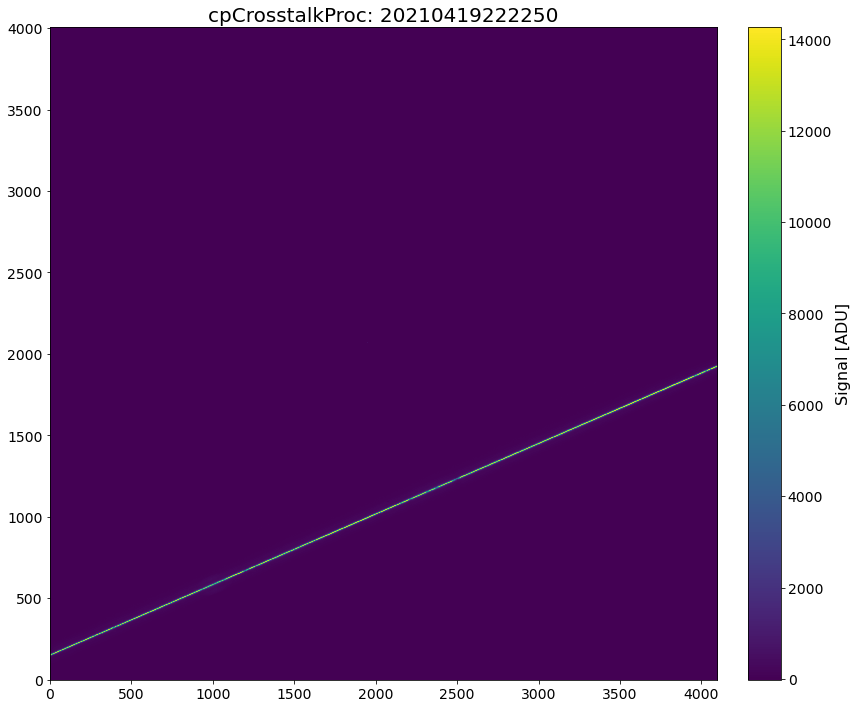

In [7]:
ref = datasetRefs[1000]
calexp = butler.get(ref, collections='u/asnyder/satellite_20210419/crosstalk_satellite')

## Display calibrated image
fig, ax = plt.subplots(1, 1, figsize=(14, 12))
im = ax.imshow(calexp.getImage().getArray(), interpolation='none', origin='lower')
    
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Signal [ADU]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('cpCrosstalkProc: {0}'.format(ref.dataId['exposure']), fontsize=20)
fig.patch.set_facecolor('white')

Next, the number of such data points for each source/amp pair is plotted. This is done by iterating through the dataset references obtained in the original query and passing these to the `Butler` to identify the corresponding `crosstalkRatios` datasets within the repository.

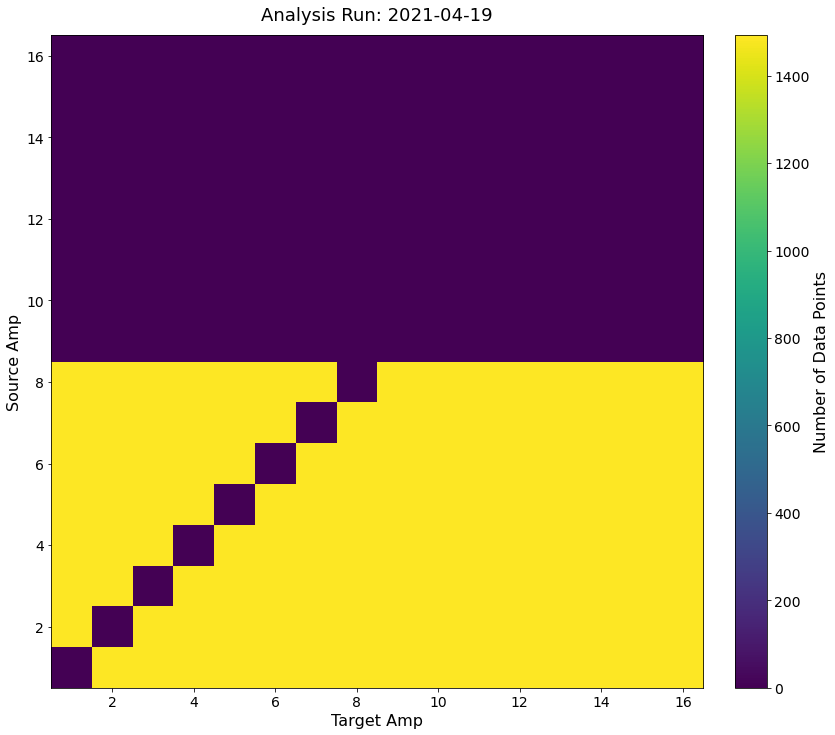

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

sensor_id = 'R00_S00'
num_datapoints = np.zeros((16, 16))

## Get corresponding ratio results
for ref in datasetRefs:
    ratios = butler.get('crosstalkRatios', dataId=ref.dataId, collections='u/asnyder/satellite_20210419/crosstalk_satellite')
    segment_ids = [key for key in ratios[sensor_id][sensor_id].keys()]

    ## Count data points for each source/target amp pair
    for source_id in segment_ids:    
        for target_id in segment_ids:

            try:
                num_datapoints[DAVIS_SEG2AMP[source_id]-1, DAVIS_SEG2AMP[target_id]-1] += len(ratios[sensor_id][sensor_id][target_id][source_id])
            except KeyError:
                continue

im = ax.imshow(num_datapoints, vmin=0, origin='lower', extent=[0.5, 16.5, 0.5, 16.5])

ax.set_title("Analysis Run: 2021-04-19", fontsize=18, pad=15)
ax.set_xlabel('Target Amp', fontsize=16)
ax.set_ylabel('Source Amp', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_label('Number of Data Points', fontsize=16)
cbar.ax.tick_params(labelsize=14)
fig.patch.set_facecolor('white')

Finally, to display the crosstalk ratios as a function of source signal, for a selection of four source/target amplifier pairs, the `Butler` is once more used with the dataset references to retrieve the corresponding `crosstalkRatios` and `crosstalkFluxes` datasets within the repository.

In the below plot, the results have been binned by the source signal in steps of 100 ADU, incrementing from 1000 ADU to the maximum signal achieved for each amplifier pair.

<ipython-input-9-4e00d82193dc>:36: RuntimeWarning: invalid value encountered in true_divide
  ax.errorbar(bin_centers, bin_coefficients, yerr=bin_std/np.sqrt(bin_count), label='Amp {0} to Amp {1}'.format(*pair))


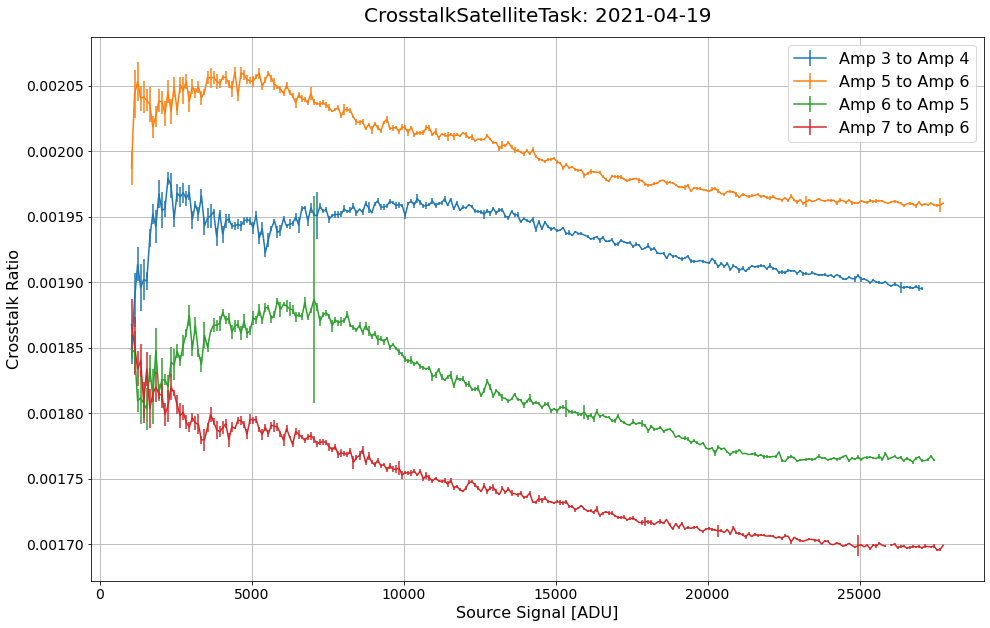

In [9]:
sensor_id = 'R00_S00'

fig, ax = plt.subplots(1, 1, figsize=(16, 10))

## Select four amp pairs to plot
pairs = [(3, 4), (5, 6), (6, 5), (7, 6)]
for pair in pairs:
    
    source_amp, target_amp = pair
    source_segment = DAVIS_AMP2SEG[source_amp]
    target_segment = DAVIS_AMP2SEG[target_amp]

    x = []
    y = []
    ## Aggregate ratio and signal measurements
    for ref in datasetRefs:
        ratios = butler.get('crosstalkRatios', dataId=ref.dataId, collections='u/asnyder/satellite_20210419/crosstalk_satellite')
        fluxes = butler.get('crosstalkFluxes', dataId=ref.dataId, collections='u/asnyder/satellite_20210419/crosstalk_satellite')

        try:
            y.append(ratios[sensor_id][sensor_id][target_segment][source_segment][0])
            x.append(fluxes[sensor_id][source_segment][0])
        except KeyError:
            continue
    
    ## Bin by steps of 100 ADU from 1000 ADU to max signal
    bins = np.arange(1000, np.max(x), 100)
    bin_coefficients, bin_edges, binnumber = binned_statistic(x, y, statistic='median', 
                                               bins=bins)
    bin_std, bin_edges, binnumber = binned_statistic(x, y, statistic='std', 
                                               bins=bins)
    bin_count, bin_edges, binnumber = binned_statistic(x, y, statistic='count', 
                                               bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    
    ax.errorbar(bin_centers, bin_coefficients, yerr=bin_std/np.sqrt(bin_count), label='Amp {0} to Amp {1}'.format(*pair))

ax.grid(True, which='major', axis='both')
ax.legend(fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('Crosstalk Ratio', fontsize=16)
ax.set_xlabel('Source Signal [ADU]', fontsize=16)
ax.set_title('CrosstalkSatelliteTask: 2021-04-19', fontsize=20, pad=15)
fig.patch.set_facecolor('white')